# Scanpy: Data integration

Three data integration methods are compared: Combat, Harmony and Scanorama.

Li J, Yu C, Ma L, Wang J, Guo G. Comparison of Scanpy-based algorithms to remove the batch effect from single-cell RNA-seq data. Cell Regen. 2020;9(1):10. 

### Setup and Load Data

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline
import scipy.sparse
import harmonypy
import scanorama

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80)

sample_name = r'granulomas'
# Path to h5 file after normalization 
h5_file_path = r'results/'
# h5_file = h5_file_path + sample_name + '_lognorm_cpm.h5ad'
h5_file = h5_file_path + sample_name + '_lognorm_scran.h5ad'

# switch to scale data
scaleit = False 
# scaleit = True 

# Path to output data
results_file_path = r'results/'
if not scaleit:
    combat_file = results_file_path + sample_name + r'_combat_corrected_scran.h5ad'  
    harmony_file = results_file_path + sample_name + r'_harmony_corrected_scran.h5ad'  
    scanorama_file = results_file_path + sample_name + r'_scanorama_corrected_scran.h5ad'
else:
    combat_file = results_file_path + sample_name + r'_scaled_combat_corrected_scran.h5ad'  
    harmony_file = results_file_path + sample_name + r'_scaled_harmony_corrected_scran.h5ad'  
    scanorama_file = results_file_path + sample_name + r'_scaled_scanorama_corrected_scran.h5ad'

scanpy==1.10.1 anndata==0.8.0 umap==0.5.3 numpy==1.26.4 scipy==1.11.4 pandas==2.2.2 scikit-learn==1.1.1 statsmodels==0.14.2 igraph==0.10.8 louvain==0.8.2 pynndescent==0.5.7


In [2]:
adata = sc.read_h5ad(h5_file)
adata.uns['log1p']["base"] = None    # bug fix

print(adata.obs['sample'].value_counts())
print()
print(adata)
print()
if scipy.sparse.issparse(adata.X):
    adata.X = scipy.sparse.csr_matrix.todense(adata.X)
print('Data matrix is sparse:', scipy.sparse.issparse(adata.X))
print()
print('X size =', adata.X.shape)

sample
granuloma2    9392
granuloma1    9302
granuloma3    8909
Name: count, dtype: int64

AnnData object with n_obs × n_vars = 27603 × 23693
    obs: 'scDblFinder_score', 'scDblFinder_class', 'doublet', 'n_genes_by_counts', 'total_counts', 'type', 'sample', 'batch_type', 'batch', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'n_genes', 'n_counts', 'size_factors'
    var: 'gene_ids', 'feature_types', 'n_cells-0', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'n_cells-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'n_cells-2', 'n_cells_by_counts-2', 'mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dr

### Zero center and standardize data
It is standard practice to zero center (subtract the mean) the features in a dataset and scale to unit variance before performing principal component analysis. 

The standard score of sample x is calculated as: z = (x - u) / s

It is debatebable whether this is a good idea for the analysis of gene expression data. Standardization is typically used when the features were measured on very different scales. The goal is not have any feature or features dominate the subsequent analysis. This is less of a problem with gene expression analysis since all features (gene expression) are measured on the same scale. If you don't standardize, high expression genes will have a greater impact than low expression and you may wish to standardize to eliminate this effect. However, the expression levels of high expression genes will have been measured more accurately than low expression genes so it makes sense to give them greater weight in the analysis. The effect usually relatively small either way due to the log1p transformation of the count data.

From best practices: https://www.embopress.org/doi/full/10.15252/msb.20188746


"In the same way that cellular count data can be normalized to make them comparable between cells, gene counts can be scaled to improve comparisons between genes. Gene normalization constitutes scaling gene counts to have zero mean and unit variance (z scores). This scaling has the effect that all genes are weighted equally for downstream analysis. There is currently no consensus on whether or not to perform normalization over genes. While the popular Seurat tutorials (Butler et al, 2018) generally apply gene scaling, the authors of the Slingshot method opt against scaling over genes in their tutorial (Street et al, 2018). The preference between the two choices revolves around whether all genes should be weighted equally for downstream analysis, or whether the magnitude of expression of a gene is an informative proxy for the importance of the gene. In order to retain as much biological information as possible from the data, we opt to refrain from scaling over genes."

In [3]:
if scaleit:
    # scale data, clip values exceeding standard deviation 10.
    sc.pp.scale(adata, max_value=10)

### Plot distribution of X
X will be either scaled on log normalized

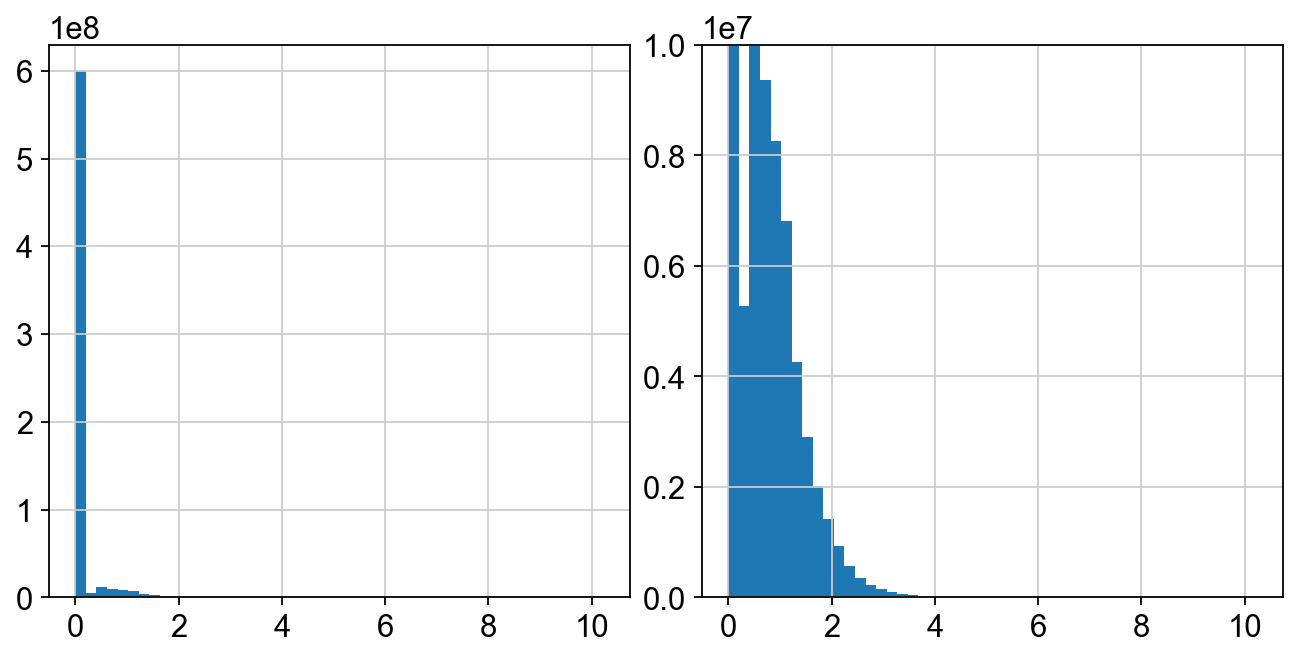

In [4]:
x=adata.X 

fig, axs = plt.subplots(1, 2, figsize=(8,4),constrained_layout=True)
hist, bins = np.histogram(x, bins=50)
width = bins[1] - bins[0]
center = (bins[:-1] + bins[1:]) / 2
axs[0].bar(center, hist, align='center', width=width)

y_limit = 1e7 # set to see counts better
plt.ylim((0,y_limit))
axs[1].bar(center, hist, align='center', width=width)
plt.show()
del x # remove dense matrix

## ComBat batch correction

ComBat batch correction requires a dense matrix format as input.

The procedure crashes sometimes. May be a memory resources error. Restarting JupyterLab fixes problem.

In [5]:
adata_combat = adata.copy() # copy with either scaled or lognorm data in X
sc.pp.combat(adata_combat, key='sample')

Standardizing Data across genes.

Found 3 batches

Found 0 numerical variables:
	

Fitting L/S model and finding priors

Finding parametric adjustments



D:\jupyter_3_10\jl\lib\site-packages\scanpy\preprocessing\_combat.py:352: RuntimeWarning: divide by zero encountered in divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


Adjusting data



## Harmony batch correction

In [6]:
adata_harmony = adata.copy()
sc.tl.pca(adata_harmony) # harmony requires pca components, has to be redone for scaled data
sce.pp.harmony_integrate(adata_harmony, 'sample')
adata_harmony.obsm['X_pca'] = adata_harmony.obsm['X_pca_harmony']  # replace X_pca it harmony pcas

computing PCA
    with n_comps=50
    finished (0:00:33)


2024-11-10 14:54:15,862 - harmonypy - INFO - Iteration 1 of 10
2024-11-10 14:54:21,481 - harmonypy - INFO - Iteration 2 of 10
2024-11-10 14:54:27,029 - harmonypy - INFO - Iteration 3 of 10
2024-11-10 14:54:31,330 - harmonypy - INFO - Converged after 3 iterations


## Scanorama Batch Correction

In [7]:
adata_scanorama = adata.copy()

Select a subset of variable genes that are identified in all batches.

In [8]:
samples = adata.obs['sample'].cat.categories.tolist()
sc.pp.highly_variable_genes(adata_scanorama, min_mean=0.0125, max_mean=3, min_disp=0.5, batch_key = 'sample')
var_select = adata_scanorama.var.highly_variable_nbatches == len(samples)
var_genes = var_select.index[var_select]
print('Number of genes variable in all samples', len(var_genes))

extracting highly variable genes
    finished (0:00:14)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Number of genes variable in all samples 2417


 Create individual AnnData objects from each of the datasets

In [9]:
# split per batch into new objects.
batches = adata_scanorama.obs['sample'].cat.categories.tolist()
alldata = {}
for batch in batches:
    alldata[batch] = adata_scanorama[adata_scanorama.obs['sample'] == batch,]

In [10]:
#subset the individual dataset to the variable genes
alldata2 = dict()
for ds in alldata.keys():
    print(ds)
    alldata2[ds] = alldata[ds][:,var_genes]
#convert to list of AnnData objects
adatas = list(alldata2.values())
# run scanorama.integrate
scanorama.integrate_scanpy(adatas, dimred = 50)

granuloma1
granuloma2
granuloma3
Found 2417 genes among all datasets
[[0.         0.88174586 0.82332473]
 [0.         0.         0.89044786]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)


In [11]:
#scanorama adds the corrected matrix to adata.obsm in each of the datasets in adatas.
adatas[0].obsm['X_scanorama'].shape

(9302, 50)

In [12]:
# Get all the integrated matrices.
scanorama_int = [ad.obsm['X_scanorama'] for ad in adatas]
# make into one matrix.
all_s = np.concatenate(scanorama_int)
print(all_s.shape)
# add to the AnnData object
adata_scanorama.obsm["Scanorama"] = all_s

(27603, 50)


### Select highly variable genes

Select for uncorrected data

extracting highly variable genes
    finished (0:00:05)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


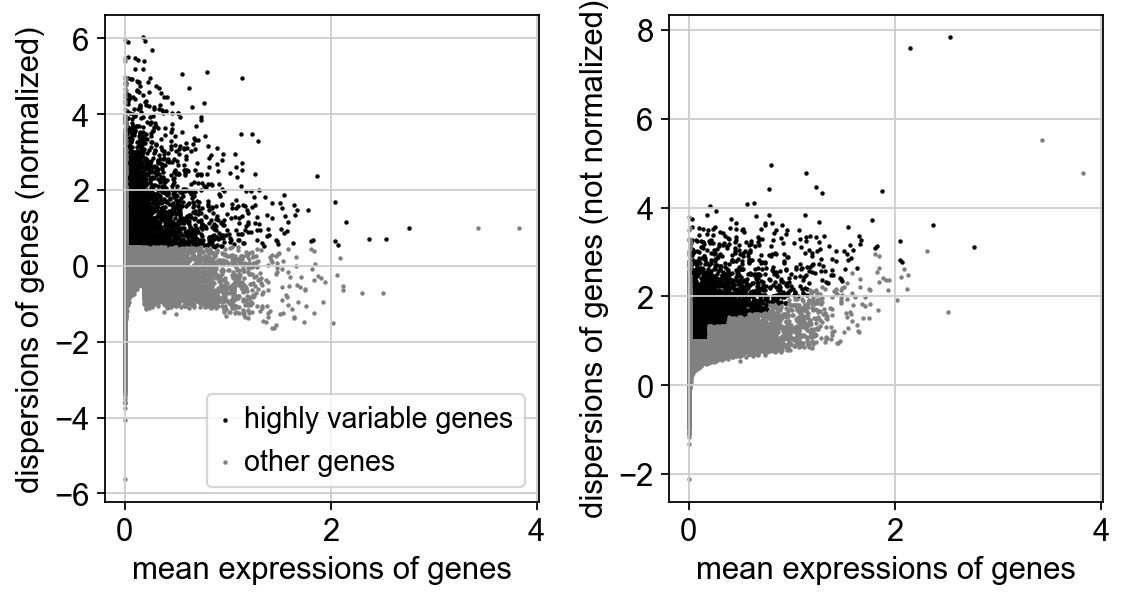

In [13]:
sc.pp.highly_variable_genes(adata)
sc.pl.highly_variable_genes(adata)

Select for combat corrected data

extracting highly variable genes
    finished (0:00:08)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


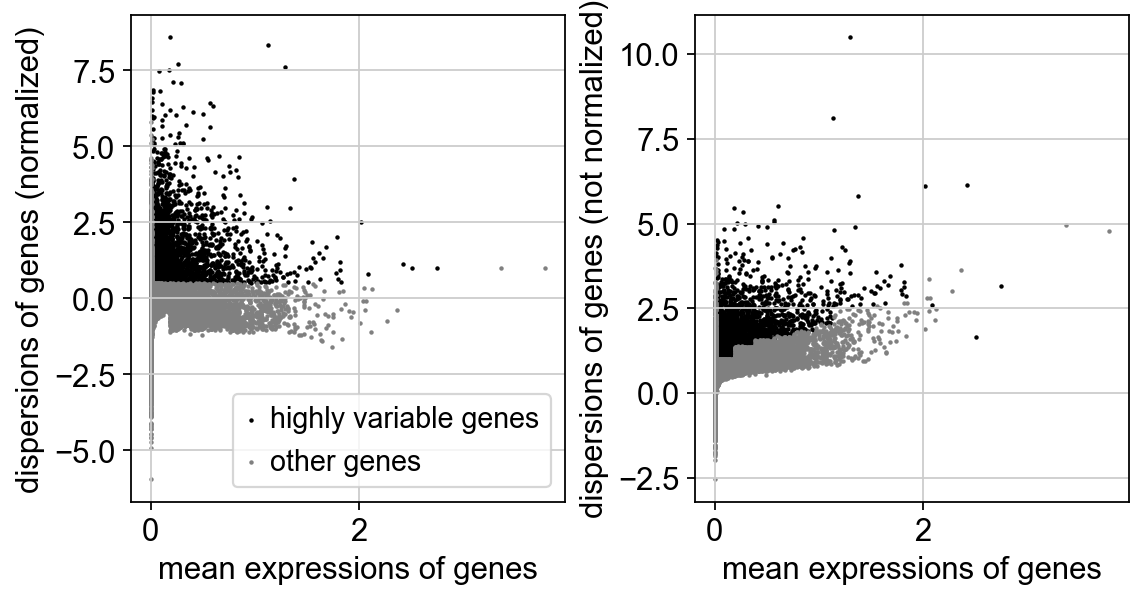

In [14]:
sc.pp.highly_variable_genes(adata_combat)
sc.pl.highly_variable_genes(adata_combat)

Select for harmony corrected data

extracting highly variable genes
    finished (0:00:05)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


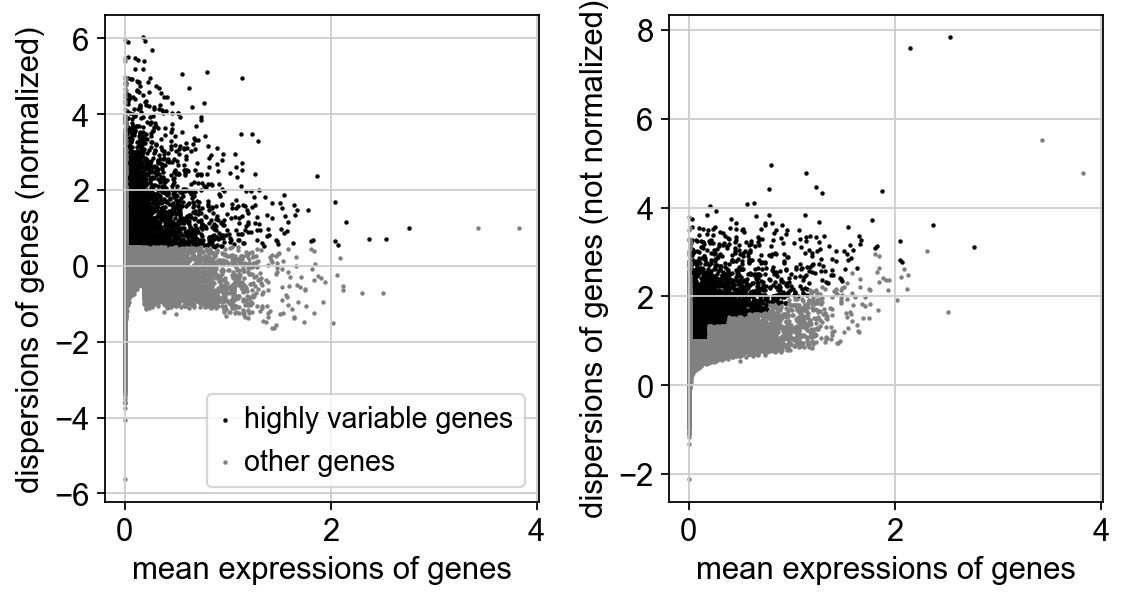

In [15]:
sc.pp.highly_variable_genes(adata_harmony)
sc.pl.highly_variable_genes(adata_harmony)

In [16]:
# compare var_genes
var_genes_all = adata.var.highly_variable
var_genes_combat = adata_combat.var.highly_variable
var_genes_harmony = adata_harmony.var.highly_variable
print("Number of Variable Genes:")
print("Uncorrected : %d"%sum(var_genes_all))
print("Combat corrected : %d"%sum(var_genes_combat))
print("Harmony corrected : %d"%sum(var_genes_harmony))
print()
print("Overlap %d"%sum(var_genes_all & var_genes_combat & var_genes_harmony))

Number of Variable Genes:
Uncorrected : 3322
Combat corrected : 3440
Harmony corrected : 3322

Overlap 3200


### PCA, UMAP, tSNE
tSNE is slow on big data sets, so skip

In [17]:
sc.pp.pca(adata, n_comps=30, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata, n_pcs =30)
sc.tl.umap(adata)
# sc.tl.tsne(adata, n_pcs = 30)

computing PCA
    with n_comps=30


D:\jupyter_3_10\jl\lib\site-packages\scanpy\preprocessing\_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
D:\jupyter_3_10\jl\lib\site-packages\scanpy\preprocessing\_pca.py:202: UserWarning: When using a mask parameter with anndata<0.9 on a dense array, the PCAcan have slightly different results due the array being column major instead of row major.
  warnings.warn(


    finished (0:00:07)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:02:30)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:15)


In [18]:
sc.pp.pca(adata_combat, n_comps=30, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata_combat, n_pcs =30)
sc.tl.umap(adata_combat)
# sc.tl.tsne(adata_combat, n_pcs = 30)

computing PCA
    with n_comps=30


D:\jupyter_3_10\jl\lib\site-packages\scanpy\preprocessing\_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
D:\jupyter_3_10\jl\lib\site-packages\scanpy\preprocessing\_pca.py:202: UserWarning: When using a mask parameter with anndata<0.9 on a dense array, the PCAcan have slightly different results due the array being column major instead of row major.
  warnings.warn(


    finished (0:00:06)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:14)


In [19]:
# don't redo pca or will overwrite harmony pcas
sc.pp.neighbors(adata_harmony, n_pcs =30)
sc.tl.umap(adata_harmony)
# sc.tl.tsne(adata_harmony, n_pcs = 30)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:15)


In [20]:
# Scanarama
sc.pp.neighbors(adata_scanorama, n_pcs = 30, use_rep = "Scanorama")
sc.tl.umap(adata_scanorama)
# sc.tl.tsne(adata_scanorama, n_pcs = 30, use_rep = "Scanorama")

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:14)


### Plot uncorrected and corrected data
Check integration of samples

<Axes: title={'center': 'Scanorama umap'}, xlabel='UMAP1', ylabel='UMAP2'>

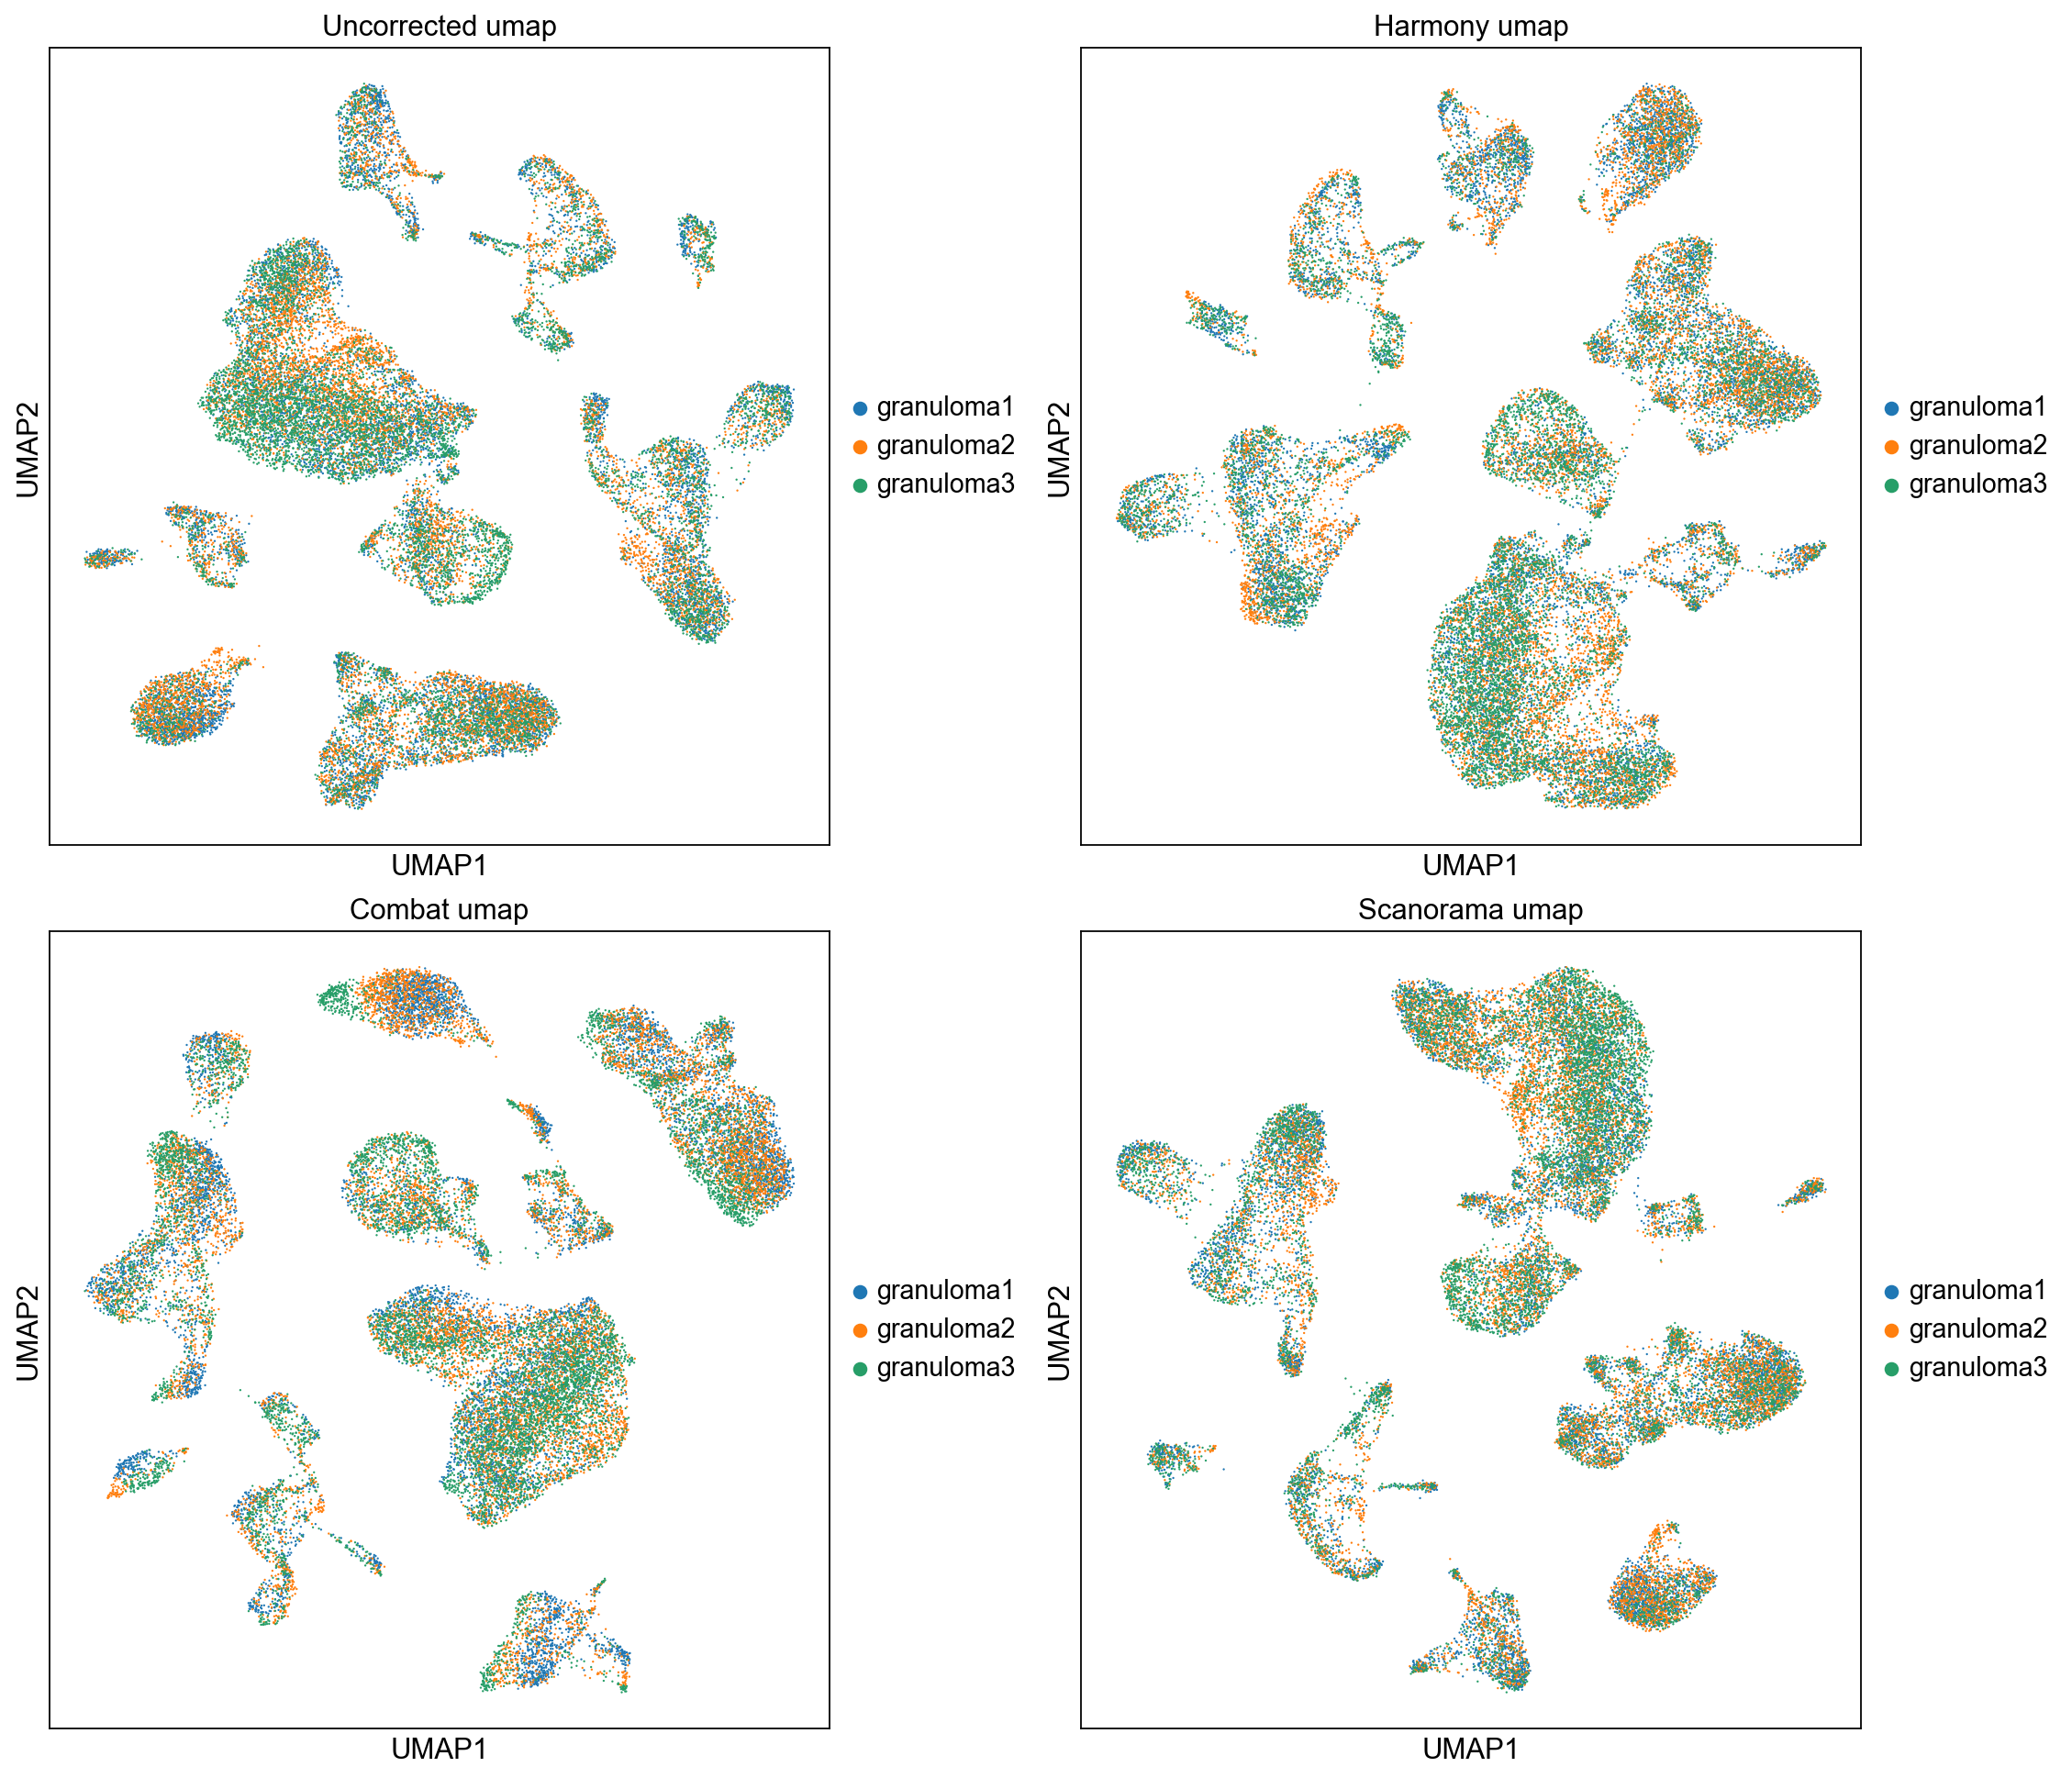

In [21]:
rcParams['figure.figsize'] = 15, 15
plt.rc('figure', facecolor='w')
fig, axs = plt.subplots(2, 2, figsize=(14,12),constrained_layout=True)
sc.pl.umap(adata, color="sample", title="Uncorrected umap", ax=axs[0,0], show=False)
sc.pl.umap(adata_combat, color="sample", title="Combat umap", ax=axs[1,0], show=False)
sc.pl.umap(adata_harmony, color="sample", title="Harmony umap", ax=axs[0,1], show=False)
sc.pl.umap(adata_scanorama, color="sample", title="Scanorama umap", ax=axs[1,1], show=False)

Check integration of experimental types

<Axes: title={'center': 'Scanorama umap'}, xlabel='UMAP1', ylabel='UMAP2'>

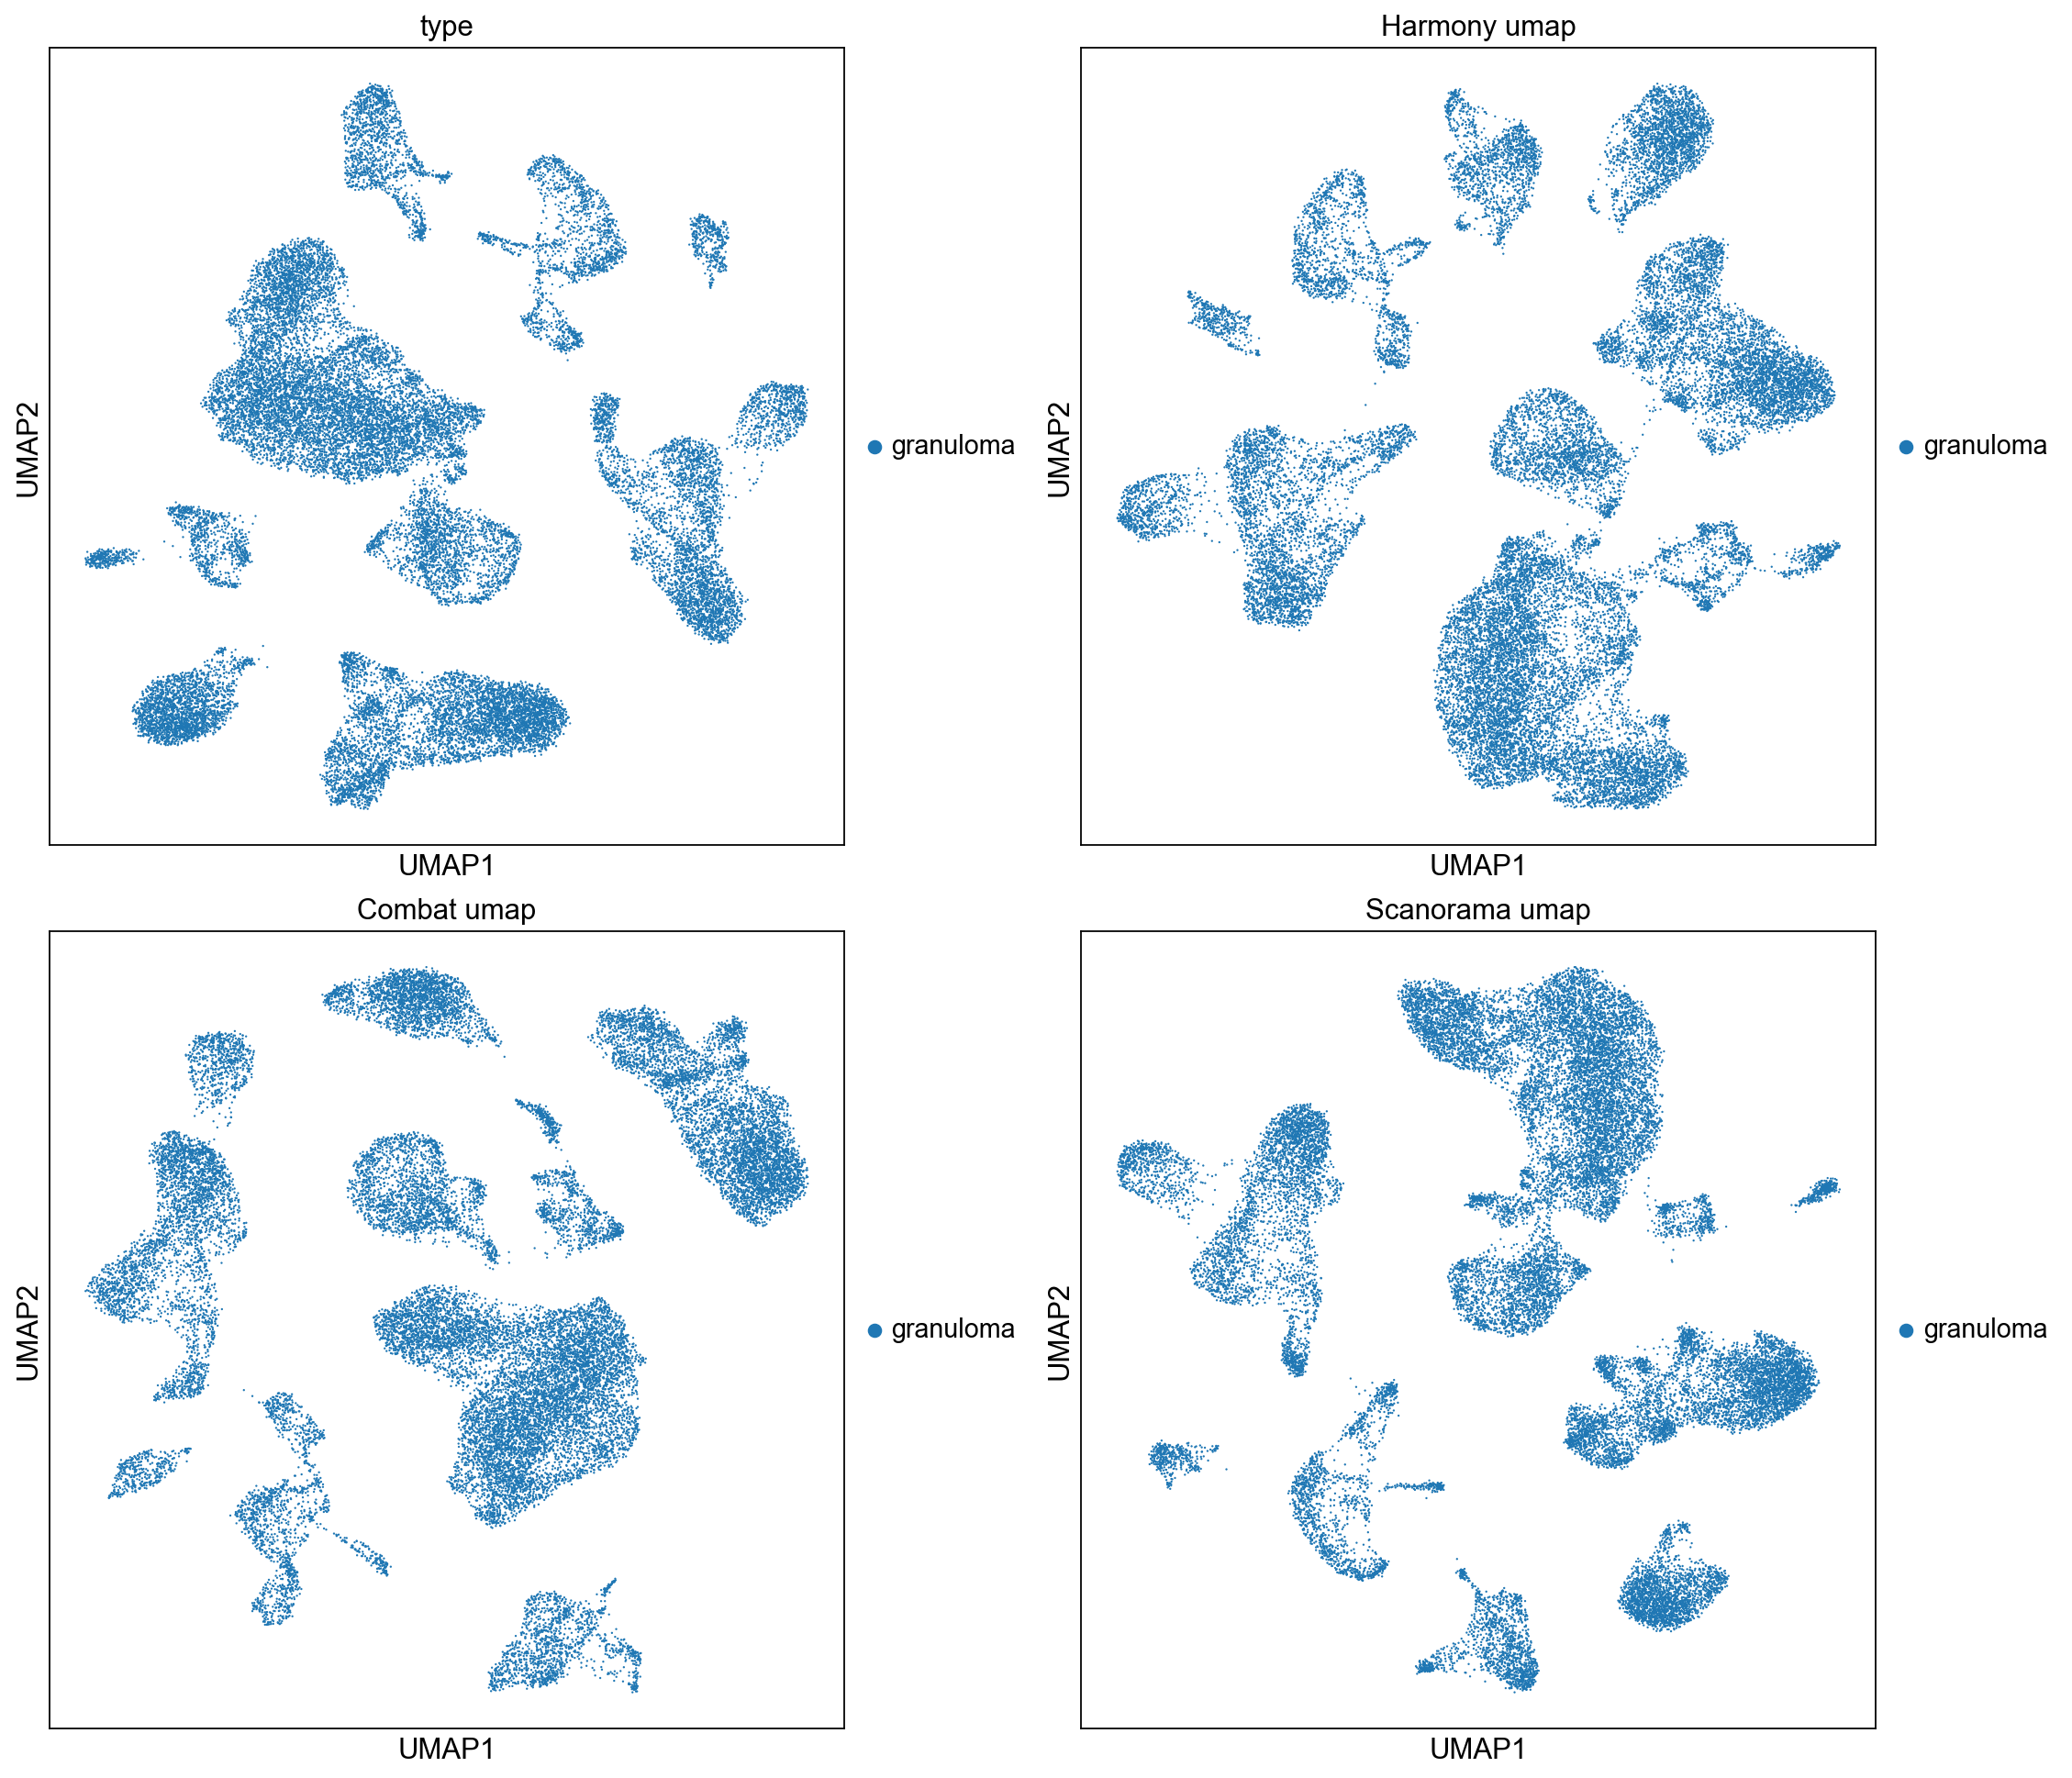

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(14,12),constrained_layout=True)
sc.pl.umap(adata, color="type", ax=axs[0,0], show=False)
sc.pl.umap(adata_combat, color="type", title="Combat umap", ax=axs[1,0], show=False)
sc.pl.umap(adata_harmony, color="type", title="Harmony umap", ax=axs[0,1], show=False)
sc.pl.umap(adata_scanorama, color="type", title="Scanorama umap", ax=axs[1,1], show=False)

### PCA Plot uncorrected and corrected data
Check integration of samples

<Axes: title={'center': 'Scanorama pca'}, xlabel='PC1', ylabel='PC2'>

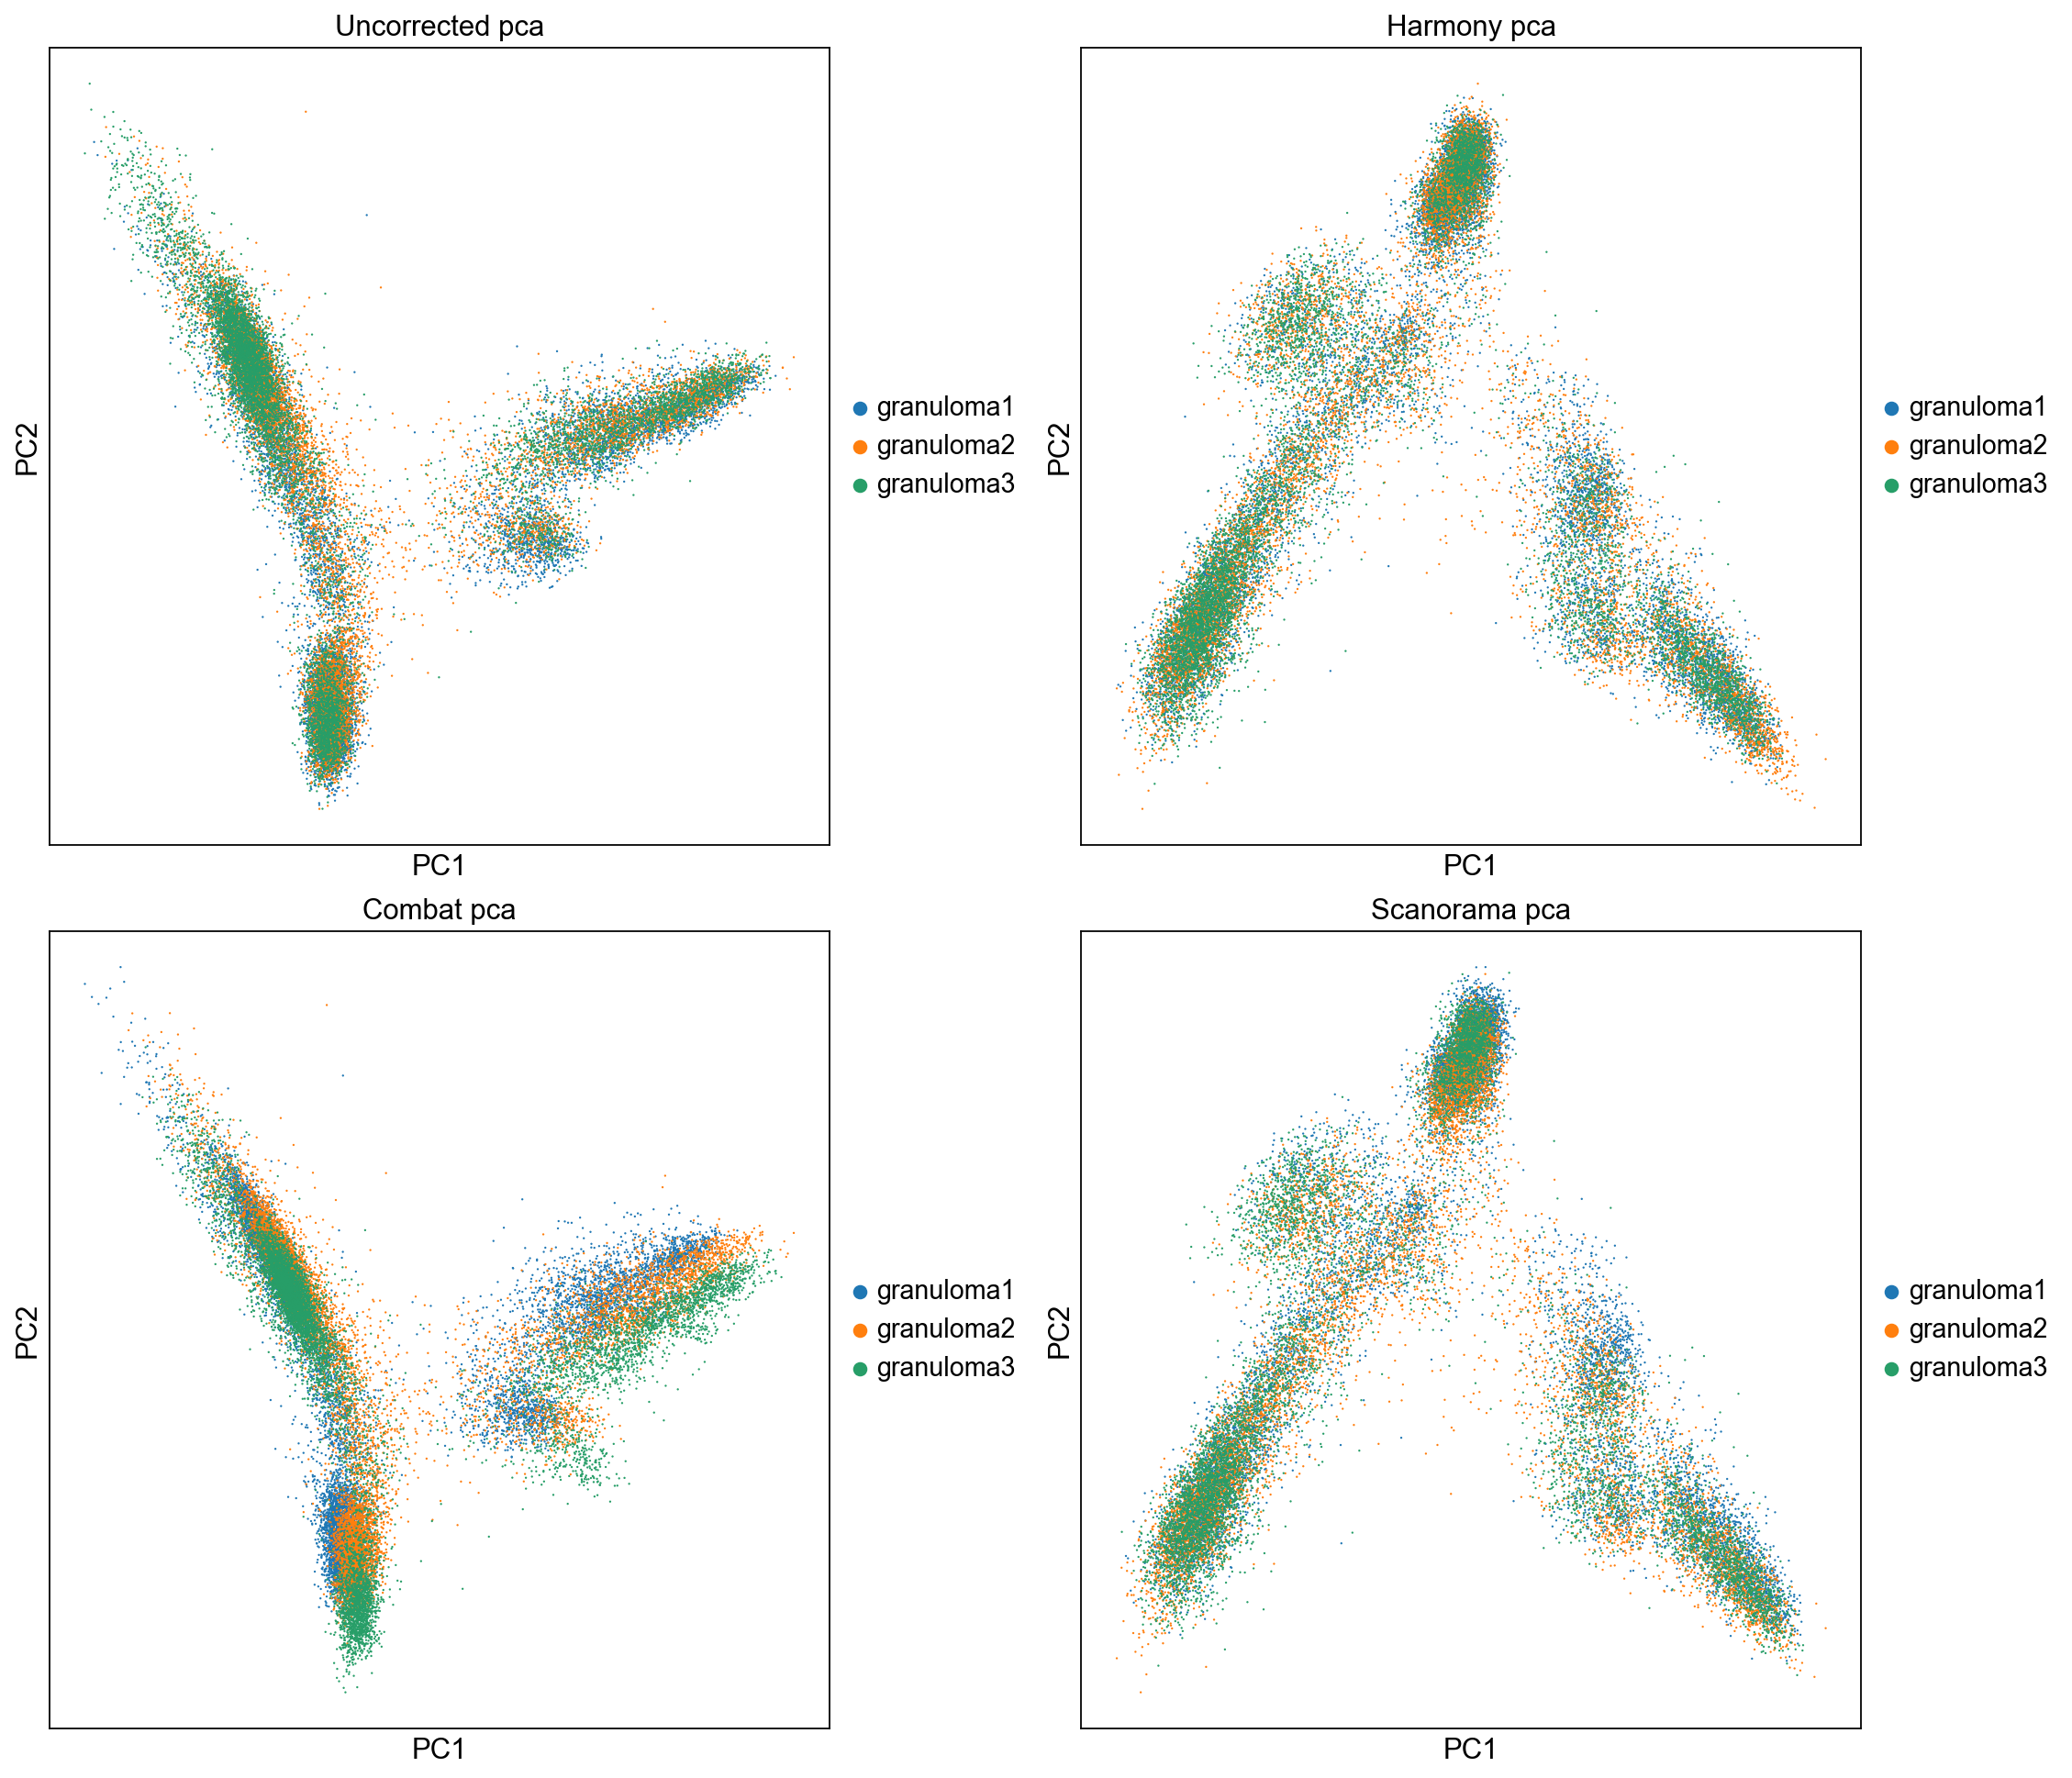

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(14,12),constrained_layout=True)
sc.pl.pca(adata, color="sample", title="Uncorrected pca", ax=axs[0,0], show=False)
sc.pl.pca(adata_combat, color="sample", title="Combat pca", ax=axs[1,0], show=False)
sc.pl.pca(adata_harmony, color="sample", title="Harmony pca", ax=axs[0,1], show=False)
sc.pl.pca(adata_scanorama, color="sample", title="Scanorama pca", ax=axs[1,1], show=False)

Check integration of experimental types

<Axes: title={'center': 'Scanorama  pca'}, xlabel='PC1', ylabel='PC2'>

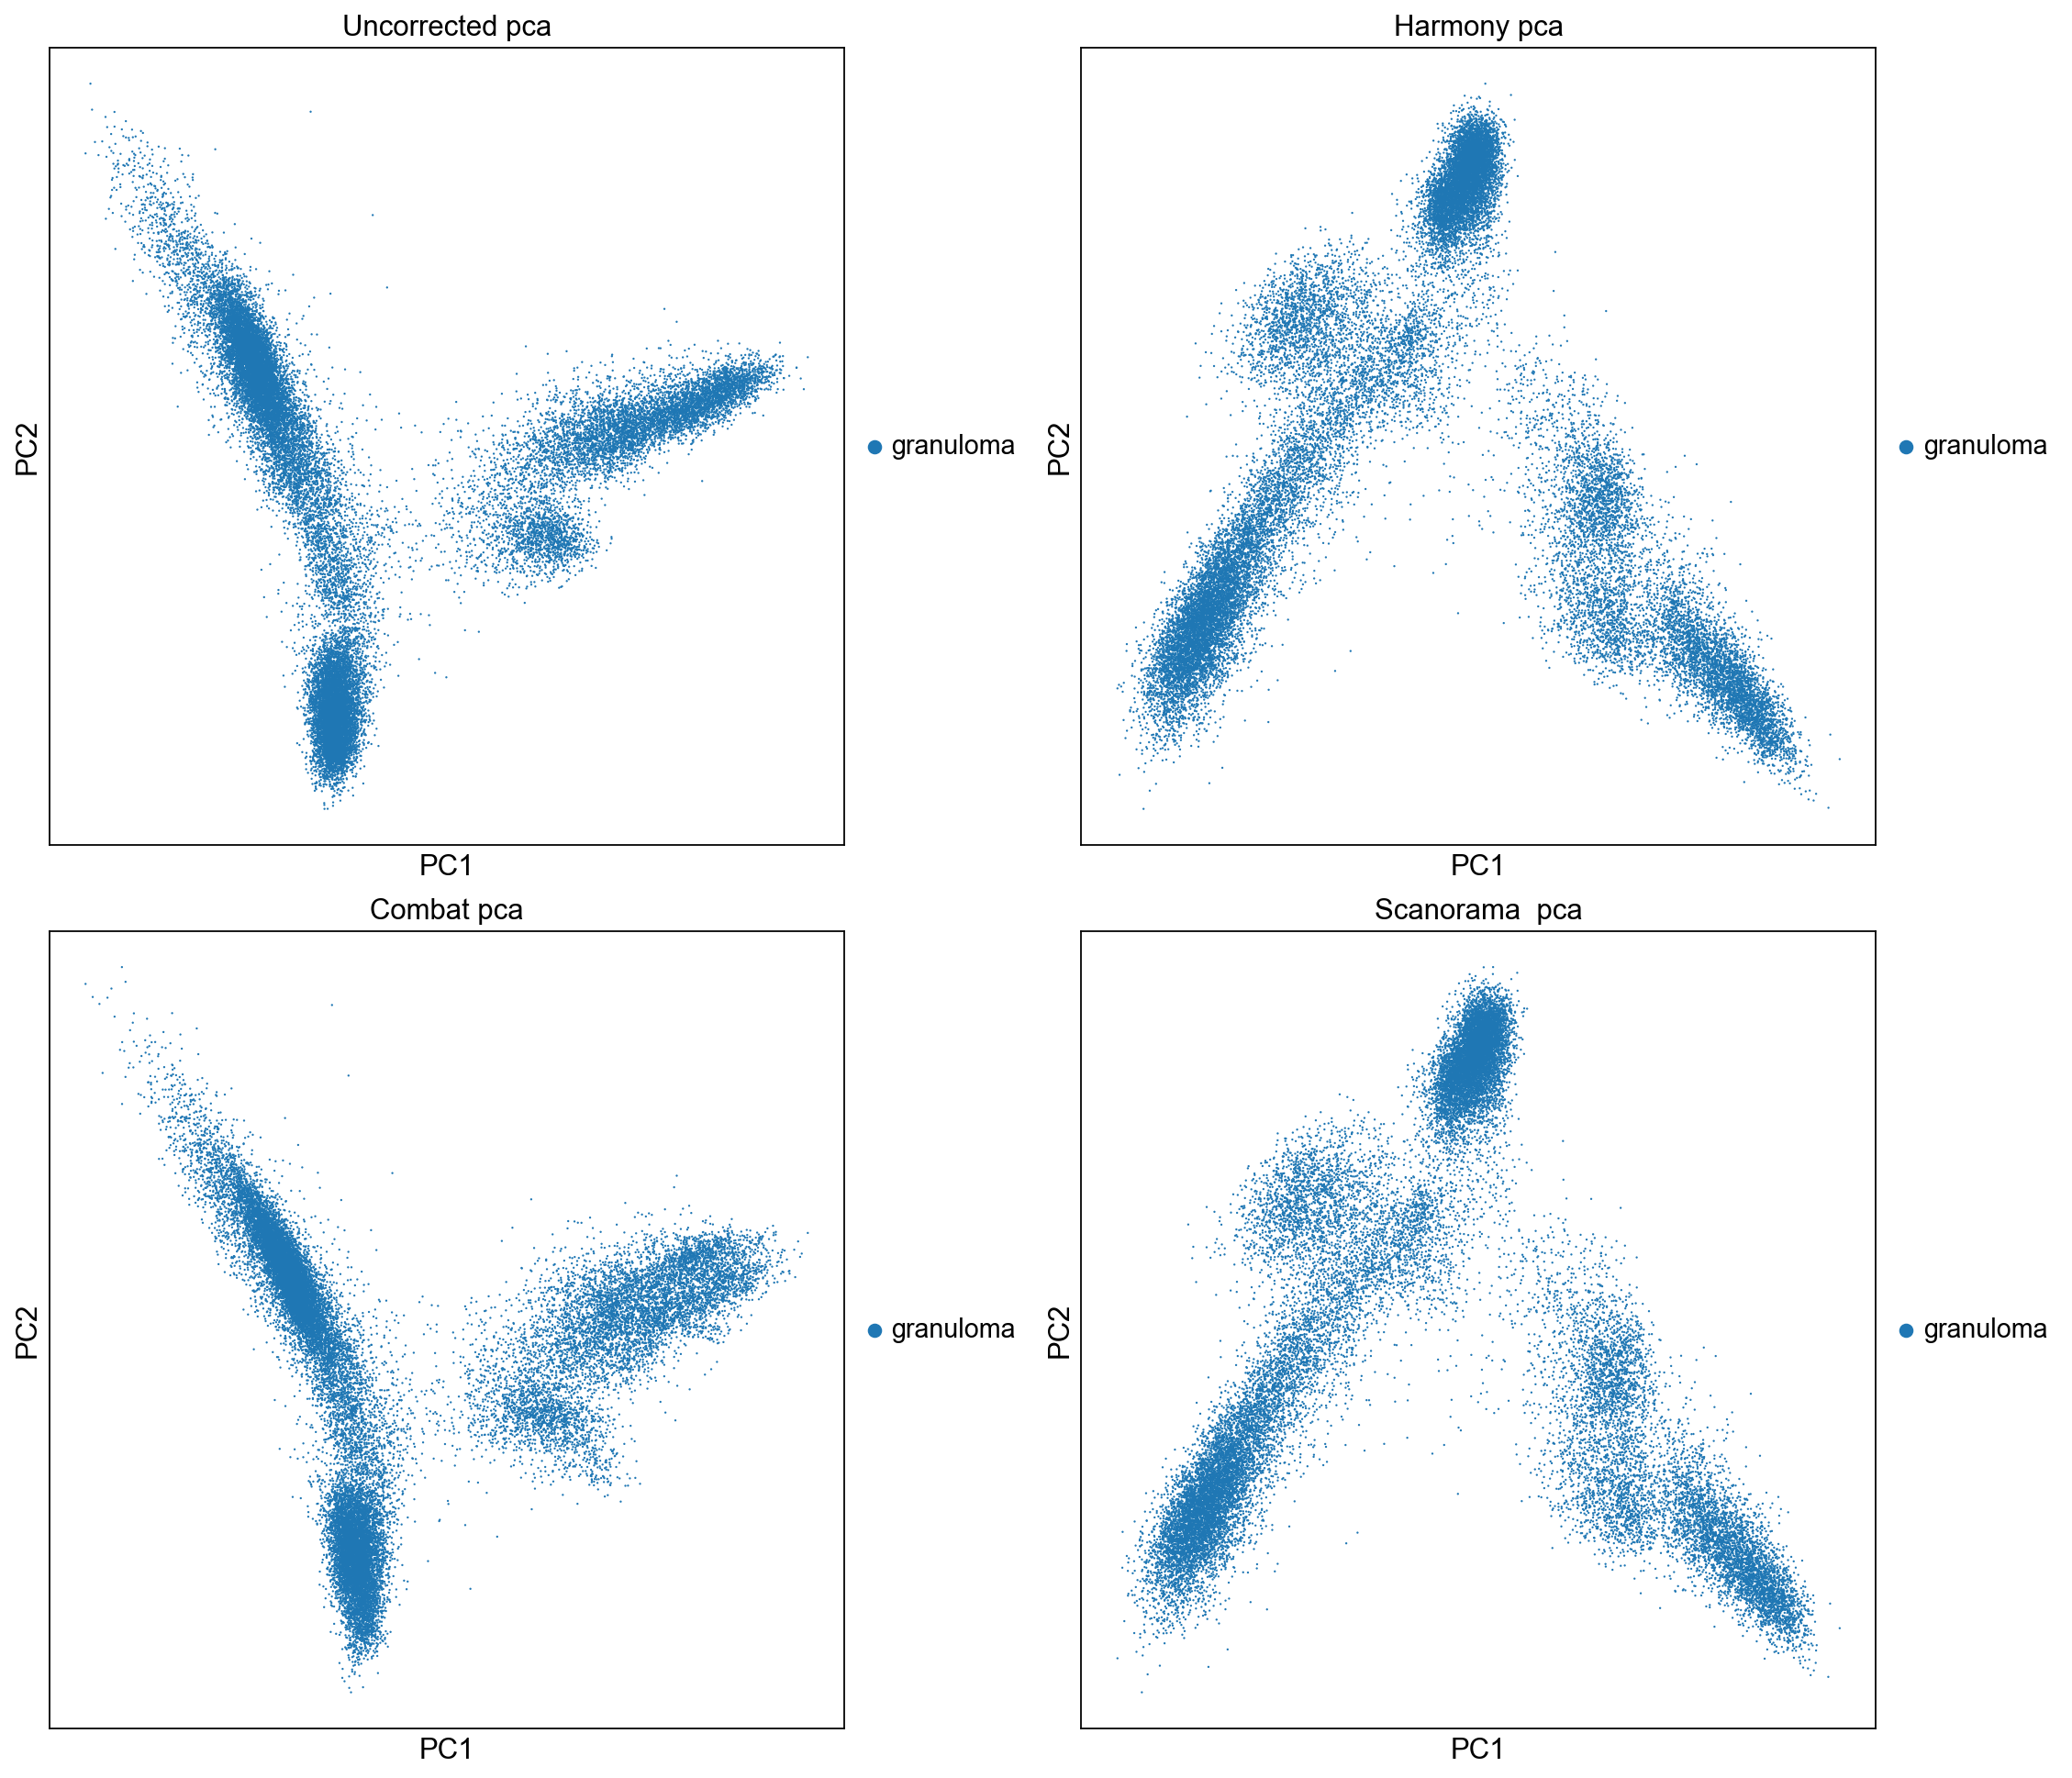

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(14,12),constrained_layout=True)
sc.pl.pca(adata, color="type", title="Uncorrected pca", ax=axs[0,0], show=False)
sc.pl.pca(adata_combat, color="type", title="Combat pca", ax=axs[1,0], show=False)
sc.pl.pca(adata_harmony, color="type", title="Harmony pca", ax=axs[0,1], show=False)
sc.pl.pca(adata_scanorama, color="type", title="Scanorama  pca", ax=axs[1,1], show=False)

### Save data

In [25]:
adata_combat.write_h5ad(combat_file)
print('X size =', adata_combat.X.shape)

X size = (27603, 23693)


In [26]:
adata_harmony.write_h5ad(harmony_file)
print('X size =', adata_combat.X.shape)

X size = (27603, 23693)


In [27]:
adata_scanorama.write_h5ad(scanorama_file)
print('X size =', adata_scanorama.X.shape)

X size = (27603, 23693)
